In [20]:
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
 
################################################################################
#############  Functions for data loading #####################################
################################################################################

## comb data 
def open_ErYb_data(data_path, header=2):
    # keys to read out as string
    key2read = ["MJD", "timer", "SDR:frep_ErYb", "fo_ErYb", "fb_Si_ErYb", "fb_Al_ErYb", "fb_Yb_ErYb"] 
    types = {key: str for key in key2read}
    types["MJD"] = float
 
    # # Read the CSV file
    data = pd.read_csv(data_path, header=1, delimiter="\t", dtype=types, engine="python")
 
    # Convert the strings to Decimal for the given keys
    for k in key2read:
        data[k] = data[k].apply(Decimal)
 
    # reindex data
    data.index = range(len(data))
 
    return data[list(types.keys())]

## Al shift data 
def open_shiftfile_Al(datapath):
    data = pd.read_csv(datapath, header=30, delimiter="\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
## Sr shift data 
def open_shiftfile_Sr(datapath):
    data = pd.read_csv(datapath, header=22, delimiter="\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
 ## Yb shift data
def open_shiftfile_Yb(datapath):
    data = pd.read_csv(datapath, header=8, delimiter=r"\t", dtype={1: str}, engine="python")
 
    # Replace column names
    data.columns = ["MJD", "shift", "IS_GOOD"]
 
    # Change column type from float to bool
    data["IS_GOOD"] = data["IS_GOOD"].apply(lambda x: x == 1.0)
 
    # Put NaN in data["shift"] where data["IS_GOOD"] is 0
    data.loc[~data["IS_GOOD"], "shift"] = np.nan
 
    # Change column type to float
    data["shift"] = data["shift"].apply(float)
 
    return data
 
################################################################################
#############  Functions to find optical frequencies with comb equation ########
################################################################################
 
# frequency for Al+ clock
def compute_nuAl_ErYb(data):
    data["nuAl"] = -Decimal("105e6") + Decimal("560444") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Al_ErYb"]
    data["nuAl"] = Decimal(4) * data["nuAl"]   

# frequency for Sr clock 
def compute_nuSr_ErYb(data):
    data["nuSi"] = -Decimal("105e6") + Decimal("388752") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - Decimal("100e6")
    data["nuSr"] = (Decimal("1716882") / Decimal("777577")) * (data["nuSi"] - Decimal("216e6"))


# freuency for Yb clock
def compute_nuYb_ErYb(data):
    data["nuYb"] = -Decimal("105e6") + Decimal("518237") * (Decimal("1e9") + data["SDR:frep_ErYb"]) / Decimal(2) - data["fb_Yb_ErYb"]
    data["nuYb"] = Decimal(2) * data["nuYb"]
 
 
################################################################################
#############################  Load data #######################################
################################################################################
 
path = "/Users/smt3/Documents/GitHub/atomic-clock/st-interp/three_clocks/"

# load comb data
data_ErYb = open_ErYb_data(path + "20240813_Deglitched_ErYb_only1.dat")
 
# load Al shift data 
shift_data_Al = open_shiftfile_Al(path + "20240813_Al+_Freq_Shifts_ErYb.dat")

# load Sr shift data
shift_data_Sr = open_shiftfile_Sr(path + "20240813_Sr_Freq_Shifts.dat")
 
# load Yb shift data
shift_data_Yb = open_shiftfile_Yb(path + "20240813_Yb_Freq_Shifts.txt")

################################################################################
###############  get optical frequencies #############################
################################################################################
 
compute_nuSr_ErYb(data_ErYb)
compute_nuYb_ErYb(data_ErYb)
compute_nuAl_ErYb(data_ErYb)
 

In [21]:
################################################################################
## Data preprocessing
################################################################################

## Extract only "IS_GOOD" shift data for analysis 
good_condition_al = shift_data_Al["IS_GOOD"] == 1
shift_data_Al_good = shift_data_Al[good_condition_al].reset_index(drop=True)
good_condition_sr = shift_data_Sr["IS_GOOD"] == 1
shift_data_Sr_good = shift_data_Sr[good_condition_sr].reset_index(drop=True)
good_condition_yb = shift_data_Yb["IS_GOOD"] == 1
shift_data_Yb_good = shift_data_Yb[good_condition_yb].reset_index(drop=True)

## Visualize missing data
import missingno as msno

#Should be no missing values in the shift files after filtering for "good" data 
print("Missing Al shift values: ", shift_data_Al_good['shift'].isna().sum())
print("Missing Sr shift values: ", shift_data_Sr_good['shift'].isna().sum())
print("Missing Yb shift values: ", shift_data_Yb_good['shift'].isna().sum())


common_mjd = data_ErYb["MJD"].astype(float)
nuAl = data_ErYb["nuAl"].astype(float)
nuSr = data_ErYb["nuSr"].astype(float)
nuYb = data_ErYb['nuYb'].astype(float)

print("Missing Al comb nu: ", nuAl.isna().sum())
print("Missing Sr comb nu: ", nuSr.isna().sum())
print("Missing Yb comb nu: ", nuYb.isna().sum())

#is_na = nuAl.isna()
#is_na = nuSr.isna()
is_na = nuYb.isna()
max_streak = current_streak = 0
for val in is_na:
    if val:
        current_streak += 1
        max_streak = max(max_streak, current_streak)
    else:
        current_streak = 0
print("Total NaNs:", is_na.sum())
print("Longest sequence of NaNs:", max_streak, '\n')


len_comb = len(common_mjd) 
len_Al = len(shift_data_Al_good['shift'])             
len_Sr = len(shift_data_Sr_good['shift'])
len_Yb = len(shift_data_Yb_good['shift'])

end_comb_inx = len_comb - 1 - max_streak
print("nuAl and nuYb start and end MJD: [", common_mjd[0], ', ', common_mjd[end_comb_inx], ']')
print("Al good shift start and end MJD: [", shift_data_Al_good['MJD'][0], ', ', shift_data_Al_good['MJD'][len_Al-1], ']')
print("Sr good shift start and end MJD: [", shift_data_Sr_good['MJD'][0], ', ', shift_data_Sr_good['MJD'][len_Sr-1], ']')
print("Yb good shift start and end MJD: [", shift_data_Yb_good['MJD'][0], ', ', shift_data_Yb_good['MJD'][len_Yb-1], ']')

last_start_time = shift_data_Sr_good['MJD'][0]
first_end_time = shift_data_Yb_good['MJD'][len_Yb-1]

Missing Al shift values:  0
Missing Sr shift values:  0
Missing Yb shift values:  0
Missing Al comb nu:  29
Missing Sr comb nu:  27
Missing Yb comb nu:  1500
Total NaNs: 1500
Longest sequence of NaNs: 1479 

nuAl and nuYb start and end MJD: [ 60535.682346 ,  60535.893888 ]
Al good shift start and end MJD: [ 60535.6818403 ,  60535.9108218 ]
Sr good shift start and end MJD: [ 60535.705143550906 ,  60535.9791847021 ]
Yb good shift start and end MJD: [ 60535.68922818 ,  60535.89320398 ]


In [22]:
#function to extract element as close to target as possible w/out going over
def lb_extract(target, data):
    inx = 0
    stopper = 1
    while stopper == 1:
        if data[inx] <= target:
            inx += 1
        else:
            return inx  

#function to extract element as close to target as possible w/out going under 
def ub_extract(target, data):
    inx = 1
    stopper = 1
    while stopper == 1:
        if data[len(data)-inx] >= target:
            inx += 1
        else:
            return len(data)-inx  


#comb MJD index 
comb = pd.DataFrame()
comb_init = lb_extract(target = last_start_time, data = common_mjd) 
comb_end = ub_extract(target = first_end_time, data = common_mjd) 
comb["MJD"] = common_mjd[comb_init:comb_end]
comb["nuAl"] = nuAl[comb_init:comb_end]
comb["nuYb"] = nuYb[comb_init:comb_end]
comb["nuSr"] = nuSr[comb_init:comb_end]

#Al MJD index 
shift_data_Al = shift_data_Al_good[lb_extract(target = last_start_time, data = shift_data_Al_good["MJD"]):ub_extract(target = first_end_time, data = shift_data_Al_good["MJD"])]
#Sr MJD index 
shift_data_Sr = shift_data_Sr_good[0:ub_extract(target = first_end_time, data = shift_data_Sr_good["MJD"])]
#Yb MJD index  
shift_data_Yb = shift_data_Yb_good[lb_extract(target = last_start_time, data = shift_data_Yb_good["MJD"]):len_Yb-1]


In [23]:

# ## View frequency of MDJ observations in comb 
# comb["MJD_diff"] = comb.MJD.diff()
# #print(comb.columns)
# series_MJD_comb_diff = comb["MJD_diff"]
# print(series_MJD_comb_diff.dtype)
# #series_MJD_comb_diff.describe()
# unique_vals = series_MJD_comb_diff.unique()
# num_unique = len(unique_vals)
# #print(num_unique)
# #print(unique_vals)

# # View time sampling rates above as datetime rather than MJD 
# comb_dt = comb 
# comb_dt["datetime"] = comb_dt["MJD"].apply(mjd_to_datetime) 
# comb_dt["datetime_diff"] = comb_dt.datetime.diff()
# comb_dt.datetime_diff.describe()


#Note: NaN in comb means IS_GOOD = 0, based on 5 sigma deglitching
# 5 sig digits = 1 sec, ideally want a few extra sig digits in MJD values 
# five parts in 10^{-18} (ratio definition of a second) ? 5x10^{-18} desired level of precision ?"

In [24]:
################################################################################
#########################  Interpolation             ###########################
################################################################################
#interpolate missing comb nu values and then convert to high precision decimal 
nuAl = pd.to_numeric(comb['nuAl'], errors='coerce').interpolate(method='linear')
nuAl = [Decimal(i) for i in nuAl]
nuSr = pd.to_numeric(comb['nuSr'], errors='coerce').interpolate(method='linear')
nuSr = [Decimal(i) for i in nuSr]
nuYb = pd.to_numeric(comb['nuYb'], errors='coerce').interpolate(method='linear')
nuYb = [Decimal(i) for i in nuYb]

# Method 1) Use numpy.interp to interpolate Al, Sr, and Yb shift values onto comb MJD values 
shiftAl1 = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_data_Al["shift"])
shiftSr1 = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_data_Sr["shift"])
shiftYb1 = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_data_Yb["shift"])

# change Method 1 data type to high-precision Decimal
shiftAl1 = [Decimal(i) for i in shiftAl1]
shiftSr1 = [Decimal(i) for i in shiftSr1]
shiftYb1 = [Decimal(i) for i in shiftYb1]
 

In [25]:

################################################################################
#############################  Plotting  #######################################
################################################################################
 
# Ratios from 2020
YbSrRatio2020 = Decimal("1.2075070393433378482") 
AlYbRatio2020 = Decimal("2.162887127516663703")
AlSrRatio2020 = Decimal("2.611701431781463025")
 
# frequency corrections
masercorrection = Decimal("-7.36631e-12")
GR_shift_Al = Decimal("-8.114e-16")
GR_shift_Yb = Decimal("-8.109e-16")
GR_shift_Sr = Decimal("10.660e-16")
GR_shift_sea_level = Decimal("-1798.501e-16")

total_correction_Yb = Decimal("1") + GR_shift_Yb + GR_shift_sea_level + masercorrection
total_correction_Sr = Decimal("1") + GR_shift_Sr + GR_shift_sea_level + masercorrection
total_correction_Al = Decimal("1") + GR_shift_Al + GR_shift_sea_level + masercorrection



Yb/Sr ratio offset from BACON paper (Method 1) -7.9727E-17


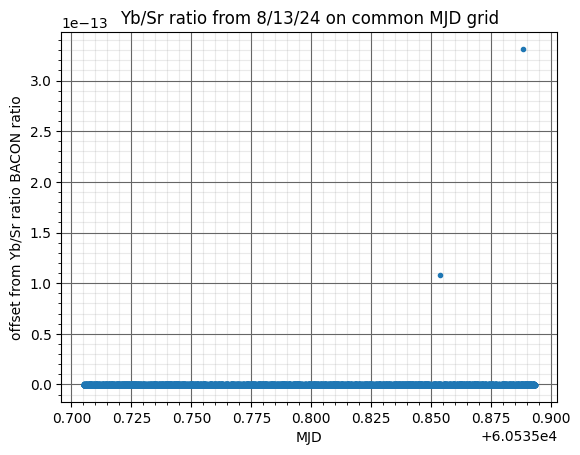

[12161, 15001]
Yb/Sr ratio offset from BACON paper  -1.0830E-16


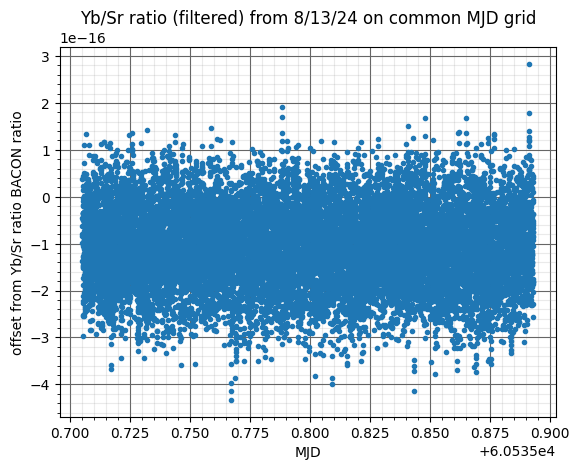

In [32]:
## Method 1)
# add comb frequencies and clock shift files
frequency_Al_ErYb1 = [(i + j) * total_correction_Al for i,j in zip(nuAl, shiftAl1)]
frequency_Sr_ErYb1 = [(i + j) * total_correction_Sr for i,j in zip(nuSr, shiftSr1)]
frequency_Yb_ErYb1 = [(i + j) * total_correction_Yb for i,j in zip(nuYb, shiftYb1)]
 

## Yb/Sr ratio offset from BACON paper
frequency_ratio_ErYb1_1 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb1, frequency_Sr_ErYb1)]
print("Yb/Sr ratio offset from BACON paper (Method 1)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_1)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from 8/13/24 on common MJD grid")
plt.show()

indices_ybsr = [i for i, val in enumerate(frequency_ratio_ErYb1_1) if ((val > Decimal('0.5e-13')) )]
print(indices_ybsr)

# plot the above minus the outlier points 
filtered_frequency_ratio_ErYb1_1 = [val for i, val in enumerate(frequency_ratio_ErYb1_1) if i not in set(indices_ybsr)]
filtered_comb = [val for i, val in enumerate(comb['MJD']) if i not in set(indices_ybsr)]
print("Yb/Sr ratio offset from BACON paper ", '{:0.5}'.format(np.nanmean(filtered_frequency_ratio_ErYb1_1)) )
plt.figure()
plt.plot(filtered_comb, filtered_frequency_ratio_ErYb1_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio (filtered) from 8/13/24 on common MJD grid")
plt.show()



Al/Yb ratio offset from BACON paper (Method 1) -2.3129E-17


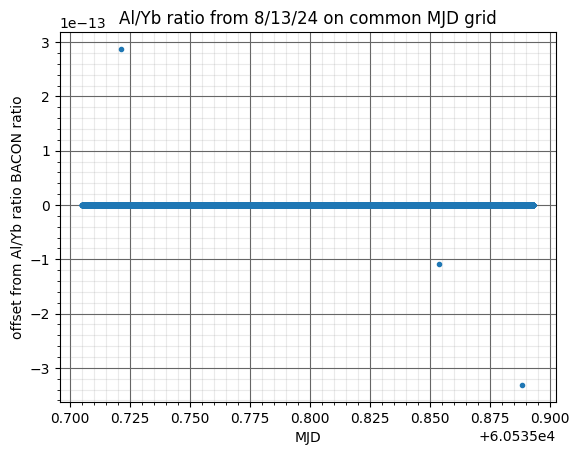

[1315, 12161, 15001]
Al/Yb ratio offset from BACON paper  -1.3241E-17


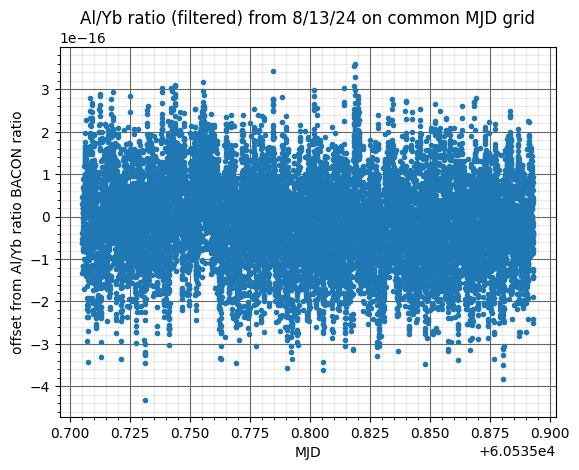

In [33]:
## Al/Yb ratio offset 
frequency_ratio_ErYb2_1 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb1, frequency_Yb_ErYb1)]
print("Al/Yb ratio offset from BACON paper (Method 1)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_1)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio from 8/13/24 on common MJD grid")
plt.show()

indices_alyb = [i for i, val in enumerate(frequency_ratio_ErYb2_1) if ((val > Decimal('0.5e-13')) or (val < Decimal('-0.5e-13')))]
print(indices_alyb)

# plot the above minus the outlier points 
filtered_frequency_ratio_ErYb2_1 = [val for i, val in enumerate(frequency_ratio_ErYb2_1) if i not in set(indices_alyb)]
filtered_comb = [val for i, val in enumerate(comb['MJD']) if i not in set(indices_alyb)]
print("Al/Yb ratio offset from BACON paper ", '{:0.5}'.format(np.nanmean(filtered_frequency_ratio_ErYb2_1)) )
plt.figure()
plt.plot(filtered_comb, filtered_frequency_ratio_ErYb2_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio (filtered) from 8/13/24 on common MJD grid")
plt.show()


Al/Sr ratio offset from BACON paper (Method 1) -1.0346E-16


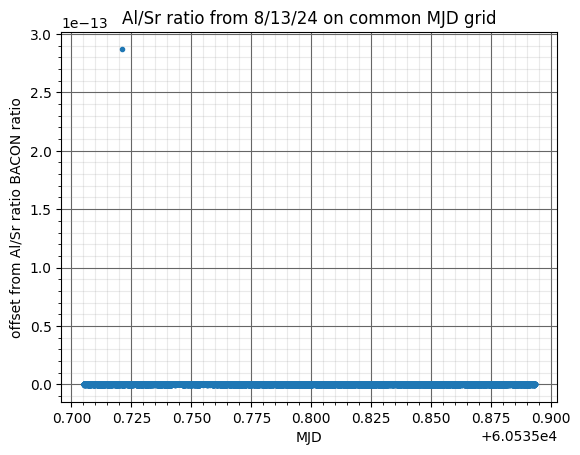

[1315]
Al/Yb ratio offset from BACON paper  -1.2213E-16


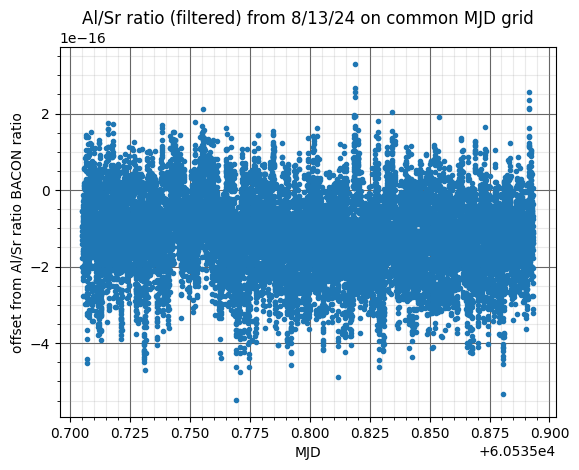

In [34]:
## Al/Sr ratio offset  
frequency_ratio_ErYb3_1 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb1, frequency_Sr_ErYb1)]
print("Al/Sr ratio offset from BACON paper (Method 1)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_1)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al/Sr ratio from 8/13/24 on common MJD grid")
plt.show()

indices_alsr = [i for i, val in enumerate(frequency_ratio_ErYb3_1) if ((val > Decimal('0.5e-13')) )]
print(indices_alsr)

# plot the above minus the outlier points 
filtered_frequency_ratio_ErYb3_1 = [val for i, val in enumerate(frequency_ratio_ErYb3_1) if i not in set(indices_alsr)]
filtered_comb = [val for i, val in enumerate(comb['MJD']) if i not in set(indices_alsr)]
print("Al/Yb ratio offset from BACON paper ", '{:0.5}'.format(np.nanmean(filtered_frequency_ratio_ErYb3_1)) )
plt.figure()
plt.plot(filtered_comb, filtered_frequency_ratio_ErYb3_1, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al/Sr ratio (filtered) from 8/13/24 on common MJD grid")
plt.show()

In [ ]:
################ Scratch work 
##TO convert MJD to datetime 

import datetime

def mjd_to_datetime(mjd):
    # MJD starts at midnight on November 17, 1858
    datetime_mjd_start = datetime.datetime(1858, 11, 17, 0, 0, 0)
    
    # Calculate the timedelta from the MJD start date
    delta = datetime.timedelta(days=mjd)
    
    # Add the timedelta to the MJD start date
    datetime_object = datetime_mjd_start + delta
    
    return datetime_object

# Example usage:
mjd_value = 58849.5  
datetime_value = mjd_to_datetime(mjd_value)
print(datetime_value)


2020-01-01 12:00:00


Yb/Sr ratio offset from BACON paper (Method 2) -1.0832E-16


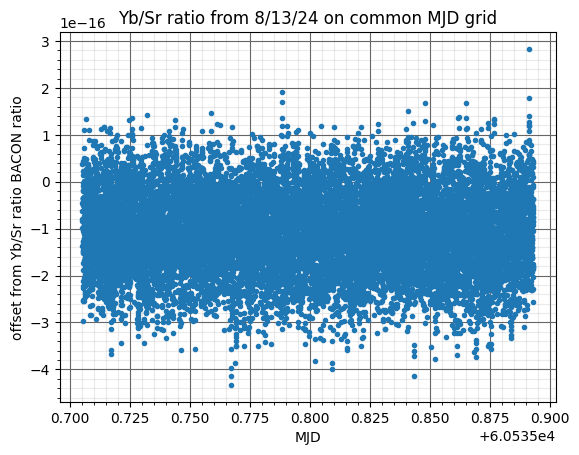

Al/Yb ratio offset from BACON paper (Method 2) -1.3185E-17


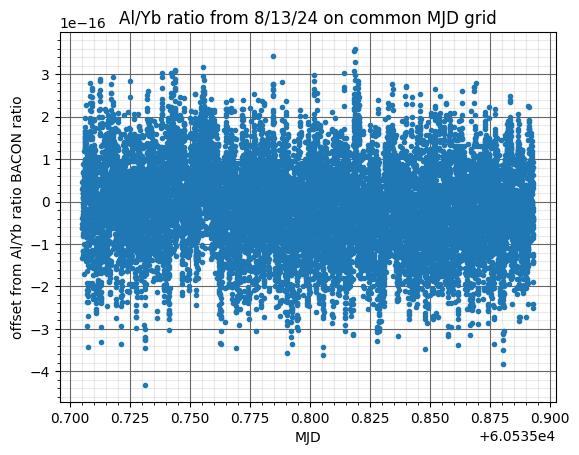

Al/Sr ratio offset from BACON paper (Method 2) -1.2210E-16


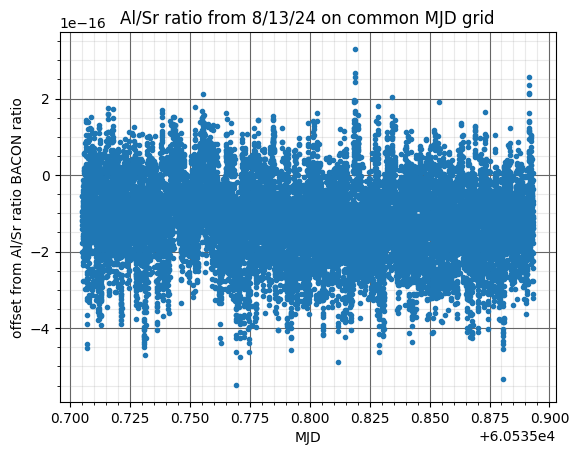

In [ ]:
#####################################################################
##### Old code - scrap for now
#####################################################################

# Method 2) Use pandas.interpolate to impute the missing data from Al, Sr, and Yb;
#           then use numpy.interp to interpolate Al, Sr, and Yb shift values onto 
#           comb MJD values
# Step 1
interp_method = "linear" #time (note: time-weighted interpolation only works on Series or DataFrames with a DatetimeIndex)
shift_Al_tmp = shift_data_Al["shift"].interpolate(method=interp_method)
shift_Sr_tmp = shift_data_Sr["shift"].interpolate(method=interp_method)
shift_Yb_tmp = shift_data_Yb["shift"].interpolate(method=interp_method)
# Step 2 
shiftAl2 = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_Al_tmp)
shiftSr2 = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_Sr_tmp)
shiftYb2 = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_Yb_tmp)

# change Method 2 data type to high-precision Decimal
shiftAl2 = [Decimal(i) for i in shiftAl2]
shiftSr2 = [Decimal(i) for i in shiftSr2]
shiftYb2 = [Decimal(i) for i in shiftYb2]

# Method 3) Same as Method 2 except don't use pandas.interpolate on any
#           sequential NaNs longer than my_limit 
# Note: this method is only useful if keeping missing data until very end of analysis (estimation) 
# Step 1
my_limit = 3
shift_Al_tmp3 = shift_data_Al["shift"].interpolate(method=interp_method, limit=my_limit)
shift_Sr_tmp3 = shift_data_Sr["shift"].interpolate(method=interp_method, limit=my_limit)
shift_Yb_tmp3 = shift_data_Yb["shift"].interpolate(method=interp_method, limit=my_limit)
# Step 2 
shiftAl3 = np.interp(comb["MJD"], shift_data_Al["MJD"], shift_Al_tmp3)
shiftSr3 = np.interp(comb["MJD"], shift_data_Sr["MJD"], shift_Sr_tmp3)
shiftYb3 = np.interp(comb["MJD"], shift_data_Yb["MJD"], shift_Yb_tmp3)

# change Method 3 data type to high-precision Decimal
shiftAl3 = [Decimal(i) for i in shiftAl3]
shiftSr3 = [Decimal(i) for i in shiftSr3]
shiftYb3 = [Decimal(i) for i in shiftYb3]


## Method 2)
# add comb frequencies and clock shift files
frequency_Yb_ErYb2 = [(i + j) * total_correction_Yb for i,j in zip(comb["nuYb"], shiftYb2)]
frequency_Sr_ErYb2 = [(i + j) * total_correction_Sr for i,j in zip(comb["nuSr"], shiftSr2)]
frequency_Al_ErYb2 = [(i + j) * total_correction_Al for i,j in zip(comb["nuAl"], shiftAl2)]
 

# Yb/Sr ratio offset from BACON paper
frequency_ratio_ErYb1_2 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb2, frequency_Sr_ErYb2)]
print("Yb/Sr ratio offset from BACON paper (Method 2)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_2)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1_2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Yb ratio offset 
frequency_ratio_ErYb2_2 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb2, frequency_Yb_ErYb2)]
print("Al/Yb ratio offset from BACON paper (Method 2)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_2)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2_2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Sr ratio offset  
frequency_ratio_ErYb3_2 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb2, frequency_Sr_ErYb2)]
print("Al/Sr ratio offset from BACON paper (Method 2)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_2)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3_2, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al/Sr ratio from 8/13/24 on common MJD grid")
plt.show()

Yb/Sr ratio offset from BACON paper (Method 3) -1.0832E-16


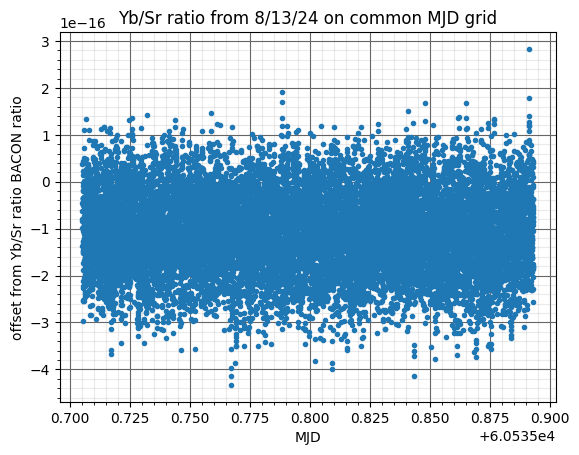

Al/Yb ratio offset from BACON paper (Method 3) -1.3185E-17


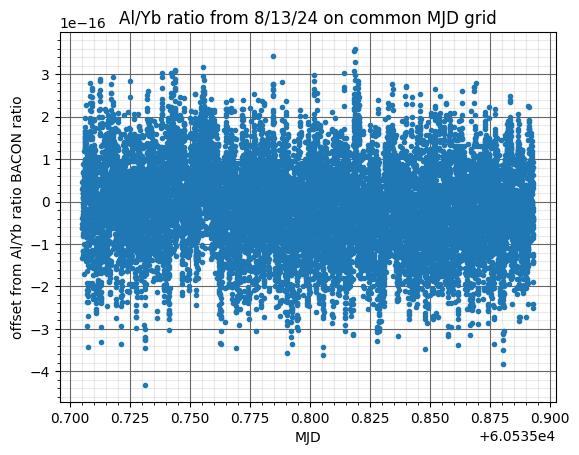

Al/Sr ratio offset from BACON paper (Method 3) -1.2210E-16


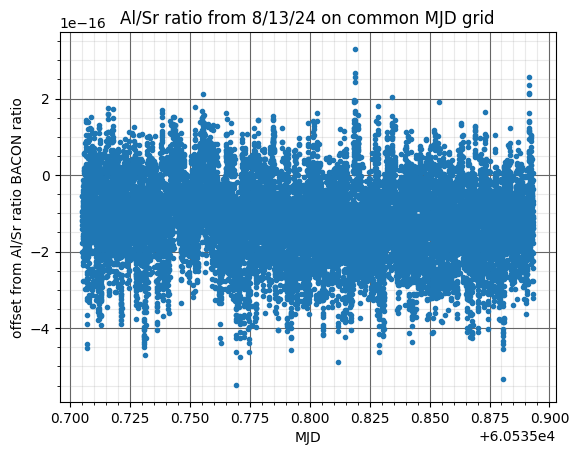

In [23]:
## Method 3)
# add comb frequencies and clock shift files
frequency_Yb_ErYb3 = [(i + j) * total_correction_Yb for i,j in zip(comb["nuYb"], shiftYb3)]
frequency_Sr_ErYb3 = [(i + j) * total_correction_Sr for i,j in zip(comb["nuSr"], shiftSr3)]
frequency_Al_ErYb3 = [(i + j) * total_correction_Al for i,j in zip(comb["nuAl"], shiftAl3)]
 

# Yb/Sr ratio offset from BACON paper
frequency_ratio_ErYb1_3 = [(i / j - YbSrRatio2020)/YbSrRatio2020 for i,j in zip(frequency_Yb_ErYb3, frequency_Sr_ErYb3)]
print("Yb/Sr ratio offset from BACON paper (Method 3)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_3)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb1_3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Yb/Sr ratio BACON ratio")
plt.title("Yb/Sr ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Yb ratio offset 
frequency_ratio_ErYb2_3 = [(i / j - AlYbRatio2020)/AlYbRatio2020 for i,j in zip(frequency_Al_ErYb3, frequency_Yb_ErYb3)]
print("Al/Yb ratio offset from BACON paper (Method 3)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_3)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb2_3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Yb ratio BACON ratio")
plt.title("Al/Yb ratio from 8/13/24 on common MJD grid")
plt.show()


# Al/Sr ratio offset  
frequency_ratio_ErYb3_3 = [(i / j - AlSrRatio2020)/AlSrRatio2020 for i,j in zip(frequency_Al_ErYb3, frequency_Sr_ErYb3)]
print("Al/Sr ratio offset from BACON paper (Method 3)", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_3)) )
 
plt.figure()
plt.plot(comb["MJD"], frequency_ratio_ErYb3_3, '.')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel("MJD")
plt.ylabel("offset from Al/Sr ratio BACON ratio")
plt.title("Al/Sr ratio from 8/13/24 on common MJD grid")
plt.show()

In [24]:
print("Method 1")
print("Mean Yb/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_1)) )
print("Mean Al/Yb:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_1)) )
print("Mean Al/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_1)) )

print("Method 2")
print("Mean Yb/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_2)) )
print("Mean Al/Yb:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_2)) )
print("Mean Al/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_2)) )

print("Method 3")
print("Mean Yb/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb1_3)) )
print("Mean Al/Yb:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb2_3)) )
print("Mean Al/Sr:", '{:0.5}'.format(np.nanmean(frequency_ratio_ErYb3_3)) )

Method 1
Mean Yb/Sr: -1.0832E-16
Mean Al/Yb: -1.3185E-17
Mean Al/Sr: -1.2210E-16
Method 2
Mean Yb/Sr: -1.0832E-16
Mean Al/Yb: -1.3185E-17
Mean Al/Sr: -1.2210E-16
Method 3
Mean Yb/Sr: -1.0832E-16
Mean Al/Yb: -1.3185E-17
Mean Al/Sr: -1.2210E-16
